In [23]:
import pandas as pd
import subprocess
import os
from google.cloud import storage
import subprocess
import re
import rasterio
import osmnx as ox
import rasterio.features
from rasterio.plot import show
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import numpy as np

In [24]:
landsat8 = pd.read_csv('./LANDSAT_8_C1_282310.csv', encoding = "ISO-8859-1", parse_dates=['Acquisition Date'])
landsat8["Acquisition Date"] = pd.to_datetime(landsat8['Acquisition Date'].dt.strftime("%Y%m%d"))

In [25]:
landsat8.shape

(128, 70)

In [26]:
# landsat8 = landsat8[(landsat8['WRS Path'] == 01) | (landsat8['WRS Path'] == 166)]

In [ ]:
# count = 0
# for idx, i in landsat8.iterrows():
#     if idx % 2 == 0 and i['WRS Path'] == 166:
#         count +=1

In [29]:
landsat8.sort_values(by='Acquisition Date', inplace=True)
landsat8.reset_index(inplace=True)
landsat8.rename(mapper={"Acquisition Date": "date"}, axis=1, inplace=True)

In [30]:
landsat8_gs = pd.DataFrame(columns=['area', 'date', 'b', 'gs_location'])

In [31]:
land8_lst = []
with open('landsat8.txt', 'r') as file:
    for line in file:
        rex = re.compile(r'.TIF')
        if rex.search(line) != None:
            land8_lst.append(line)
land8_lst[:5]

['gs://gcp-public-data-landsat/LC08/01/012/031/LC08_L1GT_012031_20130603_20170310_01_T2/LC08_L1GT_012031_20130603_20170310_01_T2_B1.TIF\n',
 'gs://gcp-public-data-landsat/LC08/01/012/031/LC08_L1GT_012031_20130603_20170310_01_T2/LC08_L1GT_012031_20130603_20170310_01_T2_B10.TIF\n',
 'gs://gcp-public-data-landsat/LC08/01/012/031/LC08_L1GT_012031_20130603_20170310_01_T2/LC08_L1GT_012031_20130603_20170310_01_T2_B11.TIF\n',
 'gs://gcp-public-data-landsat/LC08/01/012/031/LC08_L1GT_012031_20130603_20170310_01_T2/LC08_L1GT_012031_20130603_20170310_01_T2_B2.TIF\n',
 'gs://gcp-public-data-landsat/LC08/01/012/031/LC08_L1GT_012031_20130603_20170310_01_T2/LC08_L1GT_012031_20130603_20170310_01_T2_B3.TIF\n']

In [32]:
for idx, line in enumerate(land8_lst):
    dic = {}
    spl = line.split("_")
    dic["area"] = spl[2][:3]
    dic["date"] = spl[3]
    dic["b"] = spl[-1].split(".")[0]
    dic["gs_location"] = line
    landsat8_gs.loc[idx] = dic

In [33]:
landsat8_gs.shape

(2004, 4)

In [34]:
landsat8_gs = landsat8_gs[(landsat8_gs.b == 'B4') | (landsat8_gs.b == 'B3')]
landsat8_gs.reset_index(inplace=True)
landsat8_gs["date"] = pd.to_datetime(landsat8_gs["date"])

In [35]:
landsat8_gs.dtypes

index                   int64
area                   object
date           datetime64[ns]
b                      object
gs_location            object
dtype: object

In [36]:
landsat8_merged = landsat8_gs.merge(landsat8, on="date")

In [37]:
landsat8_merged

,index_x,area,date,b,gs_location,index_y,Landsat Product Identifier,Landsat Scene Identifier,Collection Category,Collection Number,...,UL Corner Long dec,UR Corner Lat dec,UR Corner Long dec,LL Corner Lat dec,LL Corner Long dec,LR Corner Lat dec,LR Corner Long dec,Display ID,Ordering ID,Browse Link
0,4,012,2013-06-03,B3,gs://gcp-public-data-landsat/LC08/01/012/031/L...,120,LC08_L1GT_012031_20130603_20170310_01_T2,LC80120312013154LGN01,T2,1,...,-72.21987,42.34167,-69.95978,41.15941,-72.71869,40.74716,-70.51364,LC08_L1GT_012031_20130603_20170310_01_T2,LC80120312013154LGN01,https://earthexplorer.usgs.gov/browse-link/128...
1,5,012,2013-06-03,B4,gs://gcp-public-data-landsat/LC08/01/012/031/L...,120,LC08_L1GT_012031_20130603_20170310_01_T2,LC80120312013154LGN01,T2,1,...,-72.21987,42.34167,-69.95978,41.15941,-72.71869,40.74716,-70.51364,LC08_L1GT_012031_20130603_20170310_01_T2,LC80120312013154LGN01,https://earthexplorer.usgs.gov/browse-link/128...
2,16,012,2014-03-02,B3,gs://gcp-public-data-landsat/LC08/01/012/031/L...,105,LC08_L1GT_012031_20140302_20180130_01_T2,LC80120312014061LGN03,T2,1,...,-72.18594,42.40210,-69.92569,41.09952,-72.72005,40.68919,-70.51875,LC08_L1GT_012031_20140302_20180130_01_T2,LC80120312014061LGN03,https://earthexplorer.usgs.gov/browse-link/128...
3,17,012,2014-03-02,B4,gs://gcp-public-data-landsat/LC08/01/012/031/L...,105,LC08_L1GT_012031_20140302_20180130_01_T2,LC80120312014061LGN03,T2,1,...,-72.18594,42.40210,-69.92569,41.09952,-72.72005,40.68919,-70.51875,LC08_L1GT_012031_20140302_20180130_01_T2,LC80120312014061LGN03,https://earthexplorer.usgs.gov/browse-link/128...
4,28,012,2014-03-02,B3,gs://gcp-public-data-landsat/LC08/01/012/031/L...,105,LC08_L1GT_012031_20140302_20180130_01_T2,LC80120312014061LGN03,T2,1,...,-72.18594,42.40210,-69.92569,41.09952,-72.72005,40.68919,-70.51875,LC08_L1GT_012031_20140302_20180130_01_T2,LC80120312014061LGN03,https://earthexplorer.usgs.gov/browse-link/128...
5,29,012,2014-03-02,B4,gs://gcp-public-data-landsat/LC08/01/012/031/L...,105,LC08_L1GT_012031_20140302_20180130_01_T2,LC80120312014061LGN03,T2,1,...,-72.18594,42.40210,-69.92569,41.09952,-72.72005,40.68919,-70.51875,LC08_L1GT_012031_20140302_20180130_01_T2,LC80120312014061LGN03,https://earthexplorer.usgs.gov/browse-link/128...
6,40,012,2015-02-17,B3,gs://gcp-public-data-landsat/LC08/01/012/031/L...,83,LC08_L1GT_012031_20150217_20170228_01_T2,LC80120312015048LGN01,T2,1,...,-72.18501,42.40139,-69.92344,41.10008,-72.71975,40.68891,-70.51715,LC08_L1GT_012031_20150217_20170228_01_T2,LC80120312015048LGN01,https://earthexplorer.usgs.gov/browse-link/128...
7,41,012,2015-02-17,B4,gs://gcp-public-data-landsat/LC08/01/012/031/L...,83,LC08_L1GT_012031_20150217_20170228_01_T2,LC80120312015048LGN01,T2,1,...,-72.18501,42.40139,-69.92344,41.10008,-72.71975,40.68891,-70.51715,LC08_L1GT_012031_20150217_20170228_01_T2,LC80120312015048LGN01,https://earthexplorer.usgs.gov/browse-link/128...
8,52,012,2015-03-05,B3,gs://gcp-public-data-landsat/LC08/01/012/031/L...,82,LC08_L1GT_012031_20150305_20170227_01_T2,LC80120312015064LGN01,T2,1,...,-72.19742,42.40109,-69.93581,41.09965,-72.73200,40.68861,-70.52935,LC08_L1GT_012031_20150305_20170227_01_T2,LC80120312015064LGN01,https://earthexplorer.usgs.gov/browse-link/128...
9,53,012,2015-03-05,B4,gs://gcp-public-data-landsat/LC08/01/012/031/L...,82,LC08_L1GT_012031_20150305_20170227_01_T2,LC80120312015064LGN01,T2,1,...,-72.19742,42.40109,-69.93581,41.09965,-72.73200,40.68861,-70.52935,LC08_L1GT_012031_20150305_20170227_01_T2,LC80120312015064LGN01,https://earthexplorer.usgs.gov/browse-link/128...


In [43]:
landsat8_merged.columns

Index(['index_x', 'area', 'date', 'b', 'gs_location', 'index_y',
       'Landsat Product Identifier', 'Landsat Scene Identifier',
       'Collection Category', 'Collection Number', 'WRS Path', 'WRS Row',
       'Target WRS Path', 'Target WRS Row', 'Nadir/Off Nadir', 'Roll Angle',
       'Date L-1 Generated', 'Start Time', 'Stop Time', 'Station Identifier',
       'Day/Night Indicator', 'Land Cloud Cover', 'Scene Cloud Cover',
       'Ground Control Points Model', 'Ground Control Points Version',
       'Geometric RMSE Model (meters)', 'Geometric RMSE Model X',
       'Geometric RMSE Model Y', 'Image Quality',
       ' Processing Software Version', 'Sun Elevation L1', 'Sun Azimuth L1',
       'TIRS SSM Model', 'Data Type Level-1', 'Sensor Identifier',
       'Panchromatic Lines', 'Panchromatic Samples', 'Reflective Lines',
       'Reflective Samples', 'Thermal Lines', 'Thermal Samples',
       'Map Projection Level-1', 'UTM Zone', 'Datum', 'Ellipsoid',
       'Grid Cell Size Panchromati

In [46]:
landsat8_merged[(landsat8_merged['Land Cloud Cover'] <= 5.75) & (landsat8_merged['Scene Cloud Cover'] <= 7.45)].shape

(70, 75)

In [39]:
landsat8_merged.isnull().sum().sum()

0

In [40]:
landsat8_merged.gs_location = landsat8_merged.gs_location.str.replace("\n", "")

In [41]:
with open('landsat8_link.txt', 'w') as f:
    for item in landsat8_merged.gs_location:
        f.write("%s\n" % item)

# Graph Of Riyadh

In [42]:
riyadh = ox.graph_from_point((24.7387, 46.6994), distance=30000, network_type='drive')
G_projected = ox.project_graph(riyadh)
ox.plot_graph(G_projected, fig_height=20, fig_width=20)

KeyboardInterrupt: 

In [4]:
nodes, edges = ox.graph_to_gdfs(riyadh)

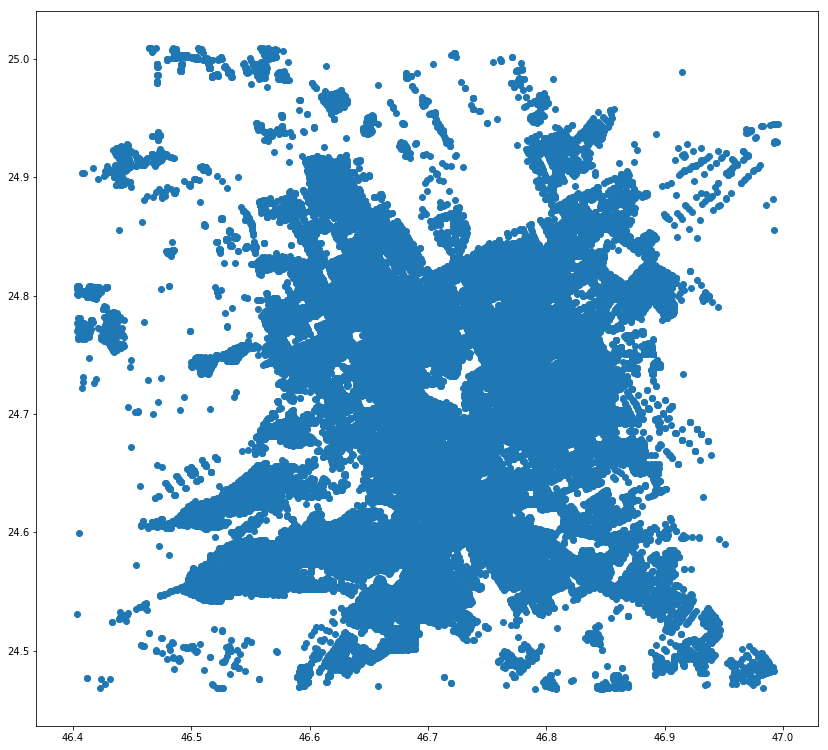

In [35]:
nodes.plot()

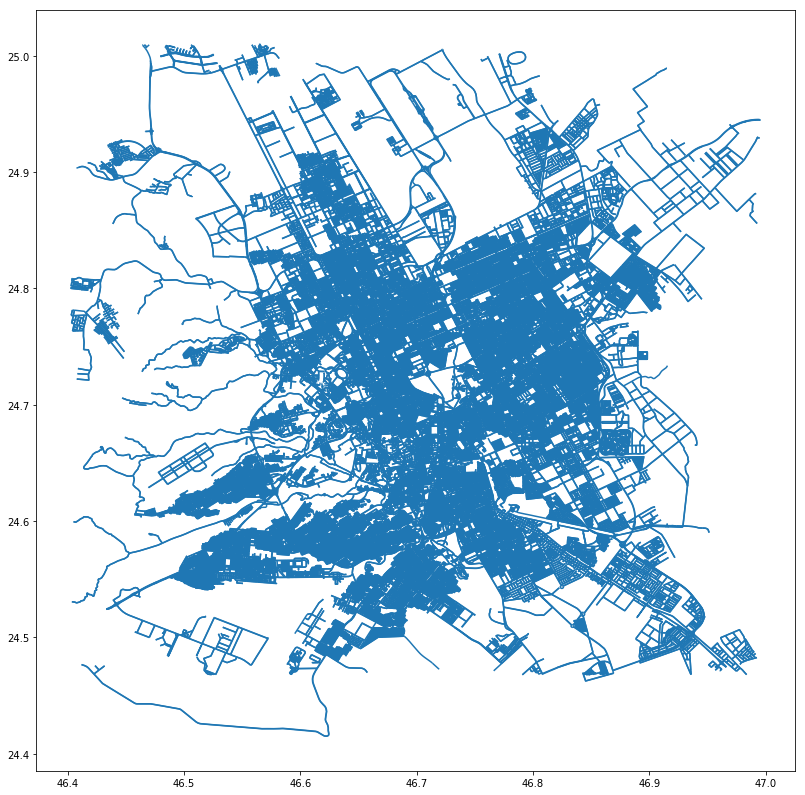

In [36]:
edges.plot()

In [3]:
merged = rasterio.open('./Other_stuff/merged2.TIF')

In [4]:
riyadh_merged = merged.read(1)

In [5]:
rasterizado = rasterio.features.rasterize(
    [(x.geometry, 1) for i, x in edges.iterrows()],
    out_shape=merged.shape,
    transform=merged.transform,
    fill=0,
    all_touched=True,
    dtype=rasterio.uint8, )


NameError: name 'edges' is not defined

In [ ]:
profile =merged.profile
profile.update(
    dtype=rasterio.uint8,
    count=1,
    compress='lzw', 
    nodata=0)
rasterizado[rasterizado < 1] = 0
with rasterio.open("./Other_stuff/RiyadhRoads.tif", 'w', **profile) as out:
    out.write_band(1, rasterizado)

In [ ]:
riyadh_raster = rasterio.open("./Other_stuff/RiyadhRoads.tif", 'r')
roads = riyadh_raster.read()

In [ ]:
roads_filtered = ndi.maximum_filter(roads, size= 5 )

In [ ]:
troads_access_osm = riyadh_merged[0] * roads_filtered[0]

plt.rcParams['figure.figsize'] = 14, 14
plt.imshow(np.log10((np.fmax( roads+1, 1))), vmin = 0, interpolation="bilinear")
bar = plt.colorbar(fraction=0.03)
bar.set_ticks([0, 0.301, 1.041, 1.708, 2.0043])
bar.set_ticklabels([0, 1, 10, 50, 100])